In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
## open csv in sublime save as utf8 encoded

df = pd.read_csv('/Users/mba/projects/mass_shootings/mass_shootings.csv', encoding = 'utf8')

## Are mass shootings getting worse?
* Are mass shooting casualties increasing?
    * are mass shooting deaths increasing?
    * are mass shootings becoming more deadly?
* Are mass shootings more frequent?
* Are mass shootings more severe?


* look at demographics
    * age
    * gender
    * race

In [3]:
df.head()

,S#,Title,Location,Date,Incident Area,Open/Close Location,Target,Cause,Summary,Fatalities,...,Total victims,Policeman Killed,Age,Employeed (Y/N),Employed at,Mental Health Issues,Race,Gender,Latitude,Longitude
0,1,Texas church mass shooting,"Sutherland Springs, TX",11/5/2017,Church,Close,random,unknown,"Devin Patrick Kelley, 26, an ex-air force offi...",26,...,46,0.0,26,NaN,NaN,No,White,M,NaN,NaN
1,2,Walmart shooting in suburban Denver,"Thornton, CO",11/1/2017,Wal-Mart,Open,random,unknown,"Scott Allen Ostrem, 47, walked into a Walmart ...",3,...,3,0.0,47,NaN,NaN,No,White,M,NaN,NaN
2,3,Edgewood businees park shooting,"Edgewood, MD",10/18/2017,Remodeling Store,Close,coworkers,unknown,"Radee Labeeb Prince, 37, fatally shot three pe...",3,...,6,0.0,37,NaN,Advance Granite Store,No,Black,M,NaN,NaN
3,4,Las Vegas Strip mass shooting,"Las Vegas, NV",10/1/2017,Las Vegas Strip Concert outside Mandala Bay,Open,random,unknown,"Stephen Craig Paddock, opened fire from the 32...",59,...,585,1.0,64,NaN,NaN,Unclear,White,M,36.181271,-115.134132
4,5,San Francisco UPS shooting,"San Francisco, CA",6/14/2017,UPS facility,Close,coworkers,NaN,"Jimmy Lam, 38, fatally shot three coworkers an...",3,...,5,0.0,38,1.0,NaN,Yes,Asian,M,NaN,NaN


In [4]:
## change data to date time and create a 'yaer' feature

df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df.loc[:, 'Date'].apply(lambda x: x.year)

In [5]:
## group by year

df_year = df.groupby('year', as_index=False).agg({'Fatalities': 'sum', 'Injured': 'sum', 
                                                 'Total victims': 'sum', 'S#': 'count'})
df_year.rename(columns={'S#':'incident_ct', 'Total victims': 'total_casualties'}, inplace=True)
df_year['casualties_per_incident'] = df_year.loc[:, ['total_casualties', 'incident_ct']].apply(lambda x: x[0] / x[1], axis=1)

df_year['year'] = df_year['year'].apply(lambda x: x - 1965)

In [6]:
## group by 5 year increments
df_year['year_5'] = df_year['year'].apply(lambda x: x // 5)
df_year_5 = df_year.groupby('year_5', as_index=False).agg({'Fatalities': 'sum', 'Injured': 'sum', 
                                                 'total_casualties': 'sum', 'incident_ct': 'sum'})
df_year_5['year_5'] = df_year_5['year_5'].apply(lambda x: (x * 5) + 1965)
df_year_5['casualties_per_incident'] = df_year_5.loc[:, 
                        ['total_casualties', 'incident_ct']].apply(lambda x: x[0] / x[1], axis=1)


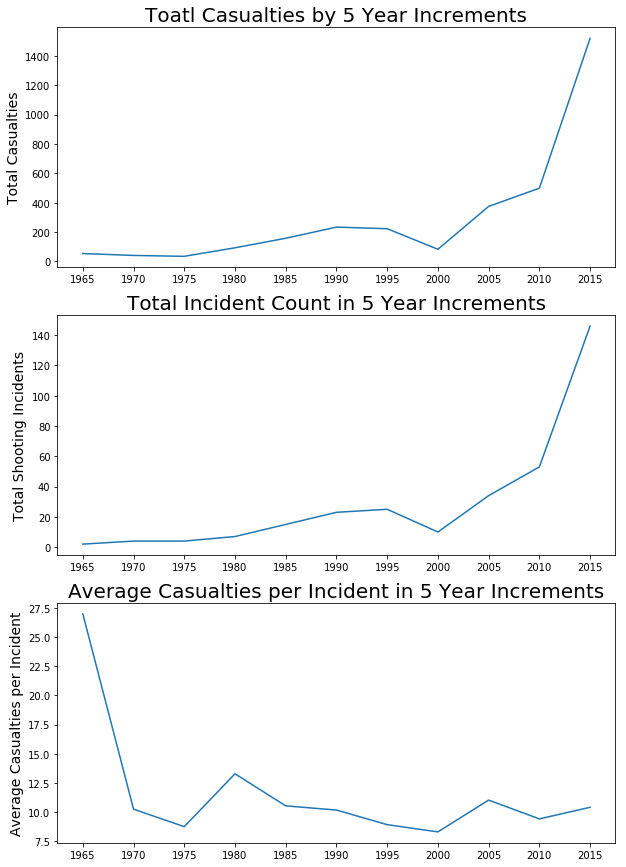

In [35]:
dims = (10,15)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=dims)
plt.setp(axes, xticks=np.arange(min(df_year_5['year_5']), max(df_year_5['year_5']) + 5, 5))


axes[0].plot(df_year_5['year_5'], df_year_5['total_casualties'])
axes[0].set_ylabel('Total Casualties', fontsize=14)
axes[0].set_title('Toatl Casualties by 5 Year Increments', fontsize=20)

axes[1].plot(df_year_5['year_5'], df_year_5['incident_ct']);
axes[1].set_ylabel('Total Shooting Incidents', fontsize = 14)
axes[1].set_title('Total Incident Count in 5 Year Increments', fontsize = 20);


axes[2].plot(df_year_5['year_5'], df_year_5['casualties_per_incident']);
axes[2].set_ylabel('Average Casualties per Incident', fontsize = 14)
axes[2].set_title('Average Casualties per Incident in 5 Year Increments', fontsize = 20);

In [10]:
## look at deaths as a percent of casualties

df_year_5['death_pct'] = df_year_5[['Fatalities', 'total_casualties']].apply(lambda x: x[0] / x[1], axis=1)

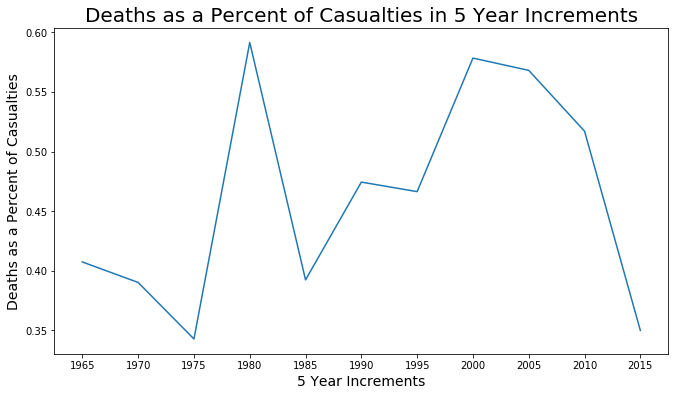

In [11]:
dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)

plt.plot(df_year_5['year_5'], df_year_5['death_pct']);
ax.set_xlabel('5 Year Increments', fontsize = 14)
ax.set_ylabel('Deaths as a Percent of Casualties', fontsize = 14)
ax.set_title('Deaths as a Percent of Casualties in 5 Year Increments', fontsize = 20);
plt.xticks(np.arange(min(df_year_5['year_5']), max(df_year_5['year_5']) + 5, 5));

In [ ]:
dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)

var = 'age'

plt.plot(df[var], df_year_5['death_pct']);
ax.set_xlabel('5 Year Increments', fontsize = 14)
ax.set_ylabel('Deaths as a Percent of Casualties', fontsize = 14)
ax.set_title('Deaths as a Percent of Casualties in 5 Year Increments', fontsize = 20);
plt.xticks(np.arange(min(df_year_5['year_5']), max(df_year_5['year_5']) + 5, 5));

Text(0.5,1,'Toatl Casualties by Year')

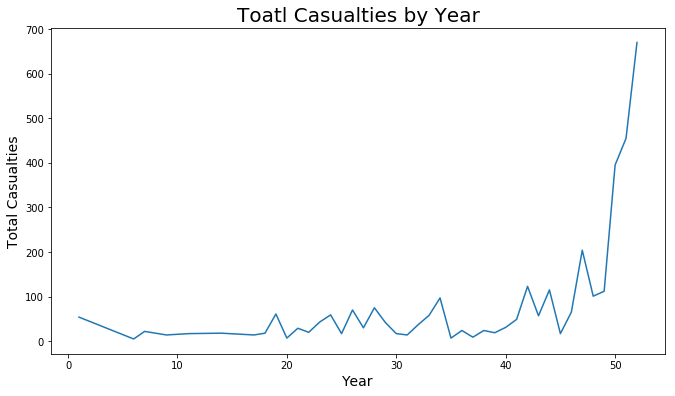

In [12]:
dims = (11,6)
fig, ax = plt.subplots(figsize=dims)

plt.plot(df_year['year'], df_year['total_casualties'])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Casualties', fontsize=14)
ax.set_title('Toatl Casualties by Year', fontsize=20)

[  1.02876069e-03   2.04477608e-01   2.19945359e+00]
[[  1.28131794e-05  -2.44318617e-04  -4.36608110e-03]
 [ -2.44318617e-04   4.66834108e-03   8.07068227e-02]
 [ -4.36608110e-03   8.07068227e-02   4.63992967e+00]]


Text(0.5,1,'Count of Shootings by Year')

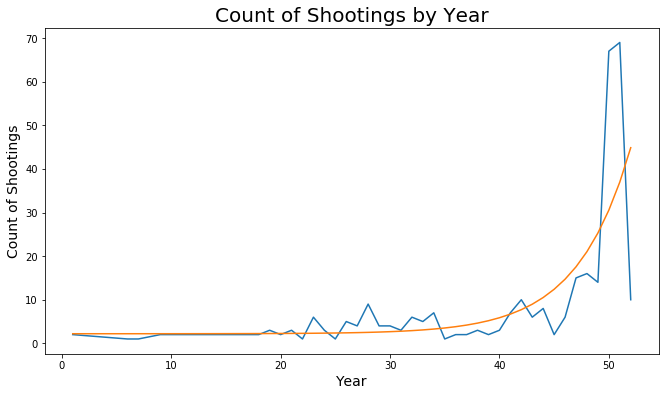

In [13]:
dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)

def exp_fit(x, a, b, c):
    return a * np.exp(b * x) + c

popt, pcov = curve_fit(exp_fit, df_year['year'], df_year['incident_ct'], p0=[1, .1, 1], maxfev=900)
print(popt)
print(pcov)
yy = exp_fit(df_year['year'], *popt)

plt.plot(df_year['year'], df_year['incident_ct'])
plt.plot(df_year['year'], yy)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Count of Shootings', fontsize=14)
ax.set_title('Count of Shootings by Year', fontsize=20)

#### note to self:
- normalize x values for line fit
- make sure the first value won't cause inf in the the func (ex: 0 in log)
- for some reason calculating yy was better not done in the plot function..


Text(0.5,1,'Toatl Fatalities by Year')

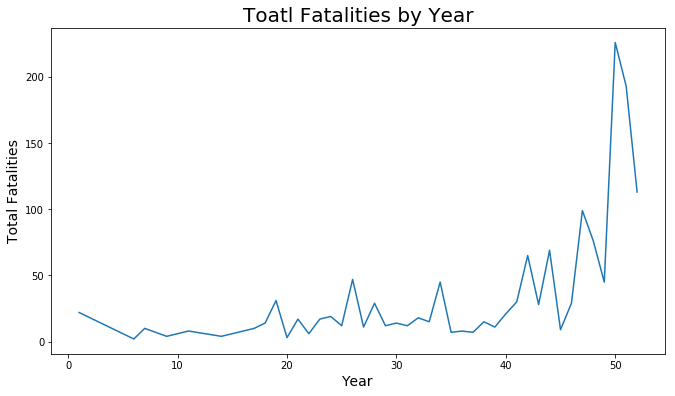

In [14]:
dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)

plt.plot(df_year['year'], df_year['Fatalities'])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Fatalities', fontsize=14)
ax.set_title('Toatl Fatalities by Year', fontsize=20)